In [1]:
%load_ext autoreload
%autoreload 2
import sys
if "../.." not in sys.path:
    sys.path.append("../..")

import numpy as np
import matplotlib.pyplot as plt
import json
from signature.signature.tensor_algebra import TensorAlgebra
from signature.signature.tensor_sequence import TensorSequence
from pricing.pricing.models.sig_vol import SigVol
from pricing.pricing.products.vanilla_option import VanillaOption
from pricing.pricing.models.model_params import LewisParams, MCParams
from pricing.pricing.utility import from_1_delta_call_to_strike

C:\Users\DM6579\Anaconda3\envs\signature\lib\site-packages\py_lets_be_rational\numba_helper.py:10: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  return jit(*jit_args, **jit_kwargs)(fun)


In [7]:
%%time
ta = TensorAlgebra(dim=2)

Compiling...
Compilation finished.
CPU times: total: 3min 3s
Wall time: 5min 30s


In [8]:
N = 5
Ø = ta.from_dict({"": 1}, trunc=N)
_1 = ta.from_dict({"1": 1}, trunc=N)
_2 = ta.from_dict({"2": 1}, trunc=N)
_11 = ta.from_dict({"11": 1}, trunc=N)
_12 = ta.from_dict({"12": 1}, trunc=N)
_21 = ta.from_dict({"21": 1}, trunc=N)
_22 = ta.from_dict({"22": 1}, trunc=N)
_222 = ta.from_word("222", trunc=N)
_221 = ta.from_word("221", trunc=N)
_121 = ta.from_word("121", trunc=N)
_211 = ta.from_word("211", trunc=N)
_2222 = ta.from_word("2222", trunc=N)
_22222 = ta.from_word("22222", trunc=N)

In [9]:
ta.print(_21.shuffle_prod(_12))

1.0*1212 + 2.0*1221 + 2.0*2112 + 1.0*2121


## Plotting

In [2]:
T = 1
F0 = 100
K = from_1_delta_call_to_strike(deltas = np.linspace(0.1, 0.9, 50), F0=F0, sigma=0.2, ttm=T)

k = np.log(K / F0)

In [5]:
green = "#5b6c64"
copper = "#B56246"

def plot_smiles(filename, ax, N, rho):
    with open(filename, 'r') as file:
        iv_dict = json.load(file)

    ax.plot(k, iv_dict["call"]["price"], "--", color=green,  label="Call")
    ax.fill_between(k, iv_dict["call"]["lower"], iv_dict["call"]["upper"], color=green, alpha=0.2)
    ax.plot(k, iv_dict["put"]["price"], color=copper, label="Put")
    ax.fill_between(k, iv_dict["put"]["lower"], iv_dict["put"]["upper"], color=copper, alpha=0.2)
    ax.grid()
    # ax.legend()
    ax.set_xlabel(r"$\log(K / S_0)$")
    ax.set_title(r"$N = $" + str(N) + r",  $\rho = $" + str(rho))


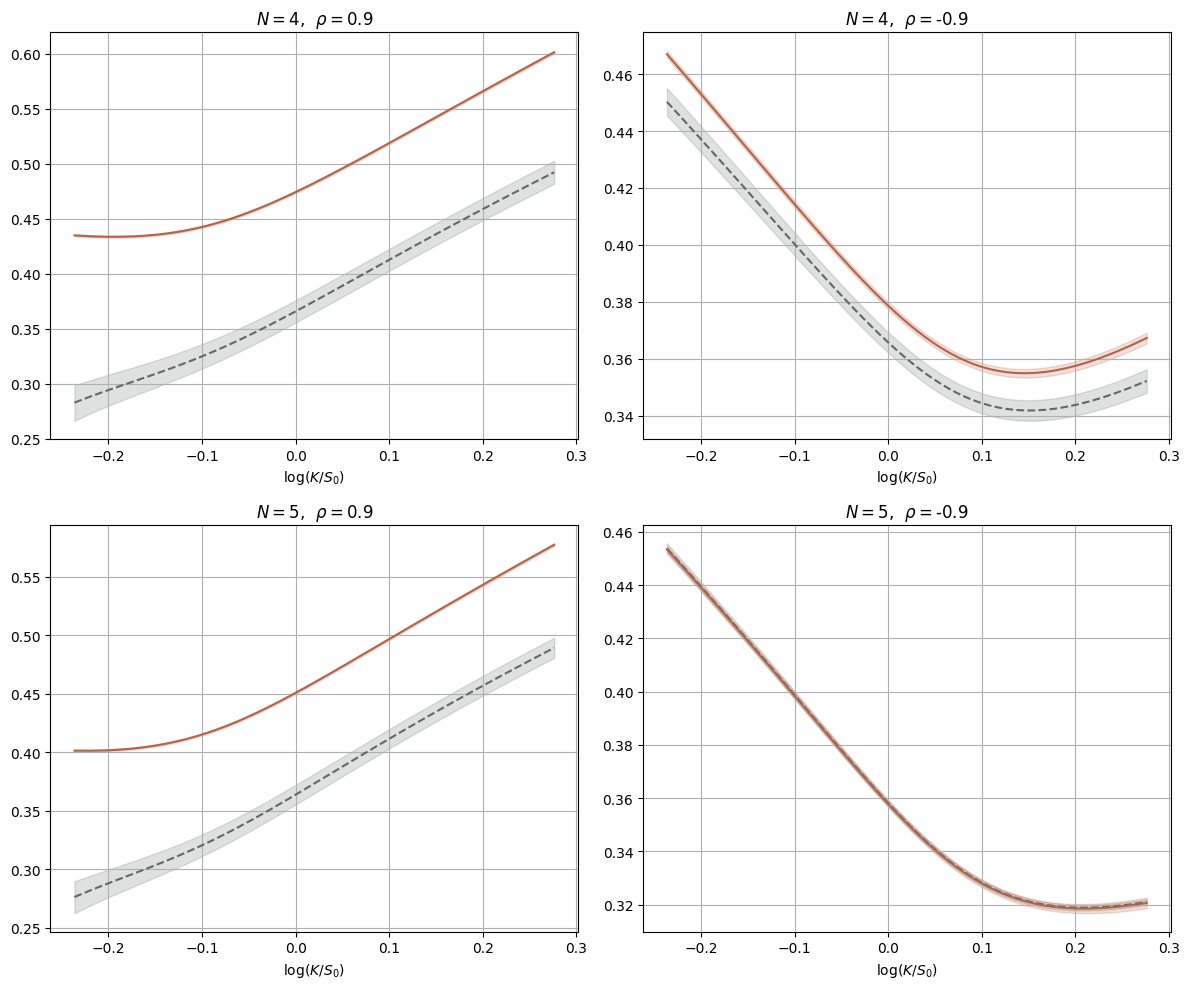

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
fig.tight_layout(pad=4)

lead_str = "_lead1"

plot_smiles(filename='results/smiles_N4_rho_pos' + lead_str + '.json', ax=ax[0, 0], N=4, rho=0.9)
plot_smiles(filename='results/smiles_N4_rho_neg' + lead_str + '.json', ax=ax[0, 1], N=4, rho=-0.9)
plot_smiles(filename='results/smiles_N5_rho_pos' + lead_str + '.json', ax=ax[1, 0], N=5, rho=0.9)
plot_smiles(filename='results/smiles_N5_rho_neg' + lead_str + '.json', ax=ax[1, 1], N=5, rho=-0.9)

fig.tight_layout()
fig.savefig("sig_smiles_1.pdf", format="pdf", transparent=True)

In [31]:
leading_coef = 0

## Strict local martingale

In [32]:
N = 4
rho = -0.9

rng = np.random.default_rng(seed=42)

len_arr = 2**(N+1) - 1
arr = np.round(rng.random(len_arr) - 0.5, 2)
arr[-1] = leading_coef
# arr = np.reshape(arr, (-1, 1, 1))
arr

array([ 0.27, -0.06,  0.36,  0.2 , -0.41,  0.48,  0.26,  0.29, -0.37,
       -0.05, -0.13,  0.43,  0.14,  0.32, -0.06, -0.27,  0.05, -0.44,
        0.33,  0.13,  0.26, -0.15,  0.47,  0.39,  0.28, -0.31, -0.03,
       -0.46, -0.35,  0.18,  0.  ])

In [33]:
model = SigVol(model_type="log-normal", 
               vol_ts=ta.from_array(trunc=N, array=arr), 
               ta=ta, 
               sigmas=lambda t: np.ones((len(t), 1)), R=[[1]], rhos=[rho])

In [34]:
ta.print(model.vol_ts)

0.27*∅ + -0.06*1 + 0.36*2 + 0.2*11 + -0.41*12 + 0.48*21 + 0.26*22 + 0.29*111 + -0.37*112 + -0.05*121 + -0.13*122 + 0.43*211 + 0.14*212 + 0.32*221 + -0.06*222 + -0.27*1111 + 0.05*1112 + -0.44*1121 + 0.33*1122 + 0.13*1211 + 0.26*1212 + -0.15*1221 + 0.47*1222 + 0.39*2111 + 0.28*2112 + -0.31*2121 + -0.03*2122 + -0.46*2211 + -0.35*2212 + 0.18*2221


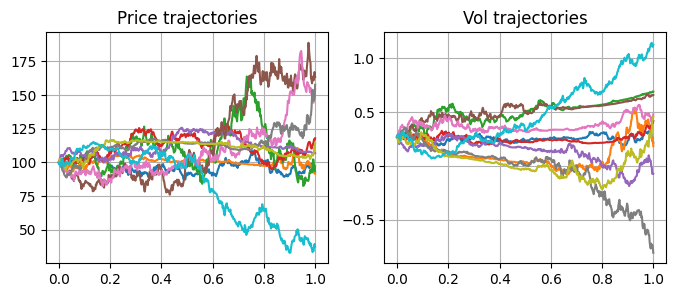

In [35]:
T = 1
F0 = 100

size = 10
N_grid = 500

t_grid = np.linspace(0, T, N_grid)
rng = np.random.default_rng(seed=42)
prices, vols = model.get_price_trajectory(t_grid=t_grid, size=size, F0=F0, rng=rng, return_vol=True)
prices

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
for price, vol in zip(prices, vols):
    ax[0].plot(t_grid, price)
    ax[1].plot(t_grid, vol)
ax[0].set_title("Price trajectories")
ax[1].set_title("Vol trajectories")
ax[0].grid()
ax[1].grid()

In [36]:
K = from_1_delta_call_to_strike(deltas = np.linspace(0.1, 0.9, 50), F0=F0, sigma=0.2, ttm=T)
option_call = VanillaOption(T=T, K=K, flag="call")
option_put = VanillaOption(T=T, K=K, flag="put")

In [37]:
%%time
smile_mc_call, mc_call_lower, mc_call_upper = option_call.get_price(
    model=model, method="mc", F0=F0, is_vol_surface=True, 
    pricing_params=MCParams(size=1_000_000, batch_size=10_000, return_accuracy=True)
)

smile_mc_put, mc_put_lower, mc_put_upper = option_put.get_price(
    model=model, method="mc", F0=F0, is_vol_surface=True, 
    pricing_params=MCParams(size=1_000_000, batch_size=10_000, return_accuracy=True)
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:01<00:00,  4.21s/it]

CPU times: total: 7min 16s
Wall time: 13min 48s


In [38]:
smile_mc_put - smile_mc_call

array([-1.16120700e-05, -1.13185518e-05, -1.10650381e-05, -1.08422883e-05,
       -1.06439889e-05, -1.04656336e-05, -1.03039122e-05, -1.01563164e-05,
       -1.00209147e-05, -9.89618923e-06, -9.78093632e-06, -9.67418583e-06,
       -9.57515376e-06, -9.48320630e-06, -9.39782997e-06, -9.31860920e-06,
       -9.24521198e-06, -9.17737878e-06, -9.11491160e-06, -9.05766465e-06,
       -9.00554548e-06, -8.95850732e-06, -8.91654542e-06, -8.87969262e-06,
       -8.84802041e-06, -8.82163847e-06, -8.80068737e-06, -8.78534427e-06,
       -8.77582343e-06, -8.77237361e-06, -8.77527875e-06, -8.78486172e-06,
       -8.80148606e-06, -8.82556783e-06, -8.85757969e-06, -8.89805082e-06,
       -8.94760617e-06, -9.00695489e-06, -9.07695778e-06, -9.15861931e-06,
       -9.25316168e-06, -9.36214481e-06, -9.48736575e-06, -9.63117080e-06,
       -9.79659586e-06, -9.98760772e-06, -1.02095538e-05, -1.04696438e-05,
       -1.07783804e-05, -1.11514714e-05])

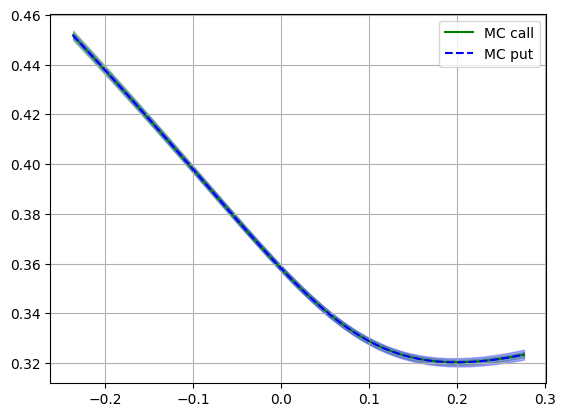

In [39]:
smile_mc_call_local_mart = smile_mc_call
smile_mc_put_local_mart = smile_mc_put

fig, ax = plt.subplots()
ax.plot(np.log(K / F0), smile_mc_call, "g", label="MC call")
ax.fill_between(np.log(K / F0), mc_call_lower, mc_call_upper, color="g", alpha=0.3)
ax.plot(np.log(K / F0), smile_mc_put, "b--", label="MC put")
ax.fill_between(np.log(K / F0), mc_put_lower, mc_put_upper, color="b", alpha=0.3)
ax.grid()
ax.legend()

In [40]:
d = dict()
d["put"] = dict()
d["put"]["price"] = smile_mc_put.tolist()
d["put"]["lower"] = mc_put_lower.tolist()
d["put"]["upper"] = mc_put_upper.tolist()

d["call"] = dict()
d["call"]["price"] = smile_mc_call.tolist()
d["call"]["lower"] = mc_call_lower.tolist()
d["call"]["upper"] = mc_call_upper.tolist()

import json
with open('smiles_N4_rho_neg' + "_lead" + str(leading_coef) + '.json', 'w') as f:
    json.dump(d, f)

## True martingale

In [41]:
N = 5
rho = -0.9


rng = np.random.default_rng(seed=42)

len_arr = 2**(N+1) - 1
arr = np.round(rng.random(len_arr) - 0.5, 2)
arr[-1] = leading_coef
# arr = np.reshape(arr, (-1, 1, 1))
arr

array([ 0.27, -0.06,  0.36,  0.2 , -0.41,  0.48,  0.26,  0.29, -0.37,
       -0.05, -0.13,  0.43,  0.14,  0.32, -0.06, -0.27,  0.05, -0.44,
        0.33,  0.13,  0.26, -0.15,  0.47,  0.39,  0.28, -0.31, -0.03,
       -0.46, -0.35,  0.18,  0.24,  0.47, -0.17, -0.13, -0.03, -0.31,
       -0.37, -0.02, -0.27,  0.17, -0.06,  0.33,  0.2 , -0.19,  0.33,
        0.3 , -0.11, -0.21,  0.18, -0.36, -0.3 , -0.49,  0.29,  0.16,
        0.21,  0.28, -0.04,  0.07, -0.36, -0.39,  0.17, -0.03,  0.  ])

In [42]:
model = SigVol(model_type="log-normal", 
               vol_ts=ta.from_array(trunc=N, array=arr), 
               ta=ta, 
               sigmas=lambda t: np.ones((len(t), 1)), R=[[1]], rhos=[rho])

In [43]:
ta.print(model.vol_ts)

0.27*∅ + -0.06*1 + 0.36*2 + 0.2*11 + -0.41*12 + 0.48*21 + 0.26*22 + 0.29*111 + -0.37*112 + -0.05*121 + -0.13*122 + 0.43*211 + 0.14*212 + 0.32*221 + -0.06*222 + -0.27*1111 + 0.05*1112 + -0.44*1121 + 0.33*1122 + 0.13*1211 + 0.26*1212 + -0.15*1221 + 0.47*1222 + 0.39*2111 + 0.28*2112 + -0.31*2121 + -0.03*2122 + -0.46*2211 + -0.35*2212 + 0.18*2221 + 0.24*2222 + 0.47*11111 + -0.17*11112 + -0.13*11121 + -0.03*11122 + -0.31*11211 + -0.37*11212 + -0.02*11221 + -0.27*11222 + 0.17*12111 + -0.06*12112 + 0.33*12121 + 0.2*12122 + -0.19*12211 + 0.33*12212 + 0.3*12221 + -0.11*12222 + -0.21*21111 + 0.18*21112 + -0.36*21121 + -0.3*21122 + -0.49*21211 + 0.29*21212 + 0.16*21221 + 0.21*21222 + 0.28*22111 + -0.04*22112 + 0.07*22121 + -0.36*22122 + -0.39*22211 + 0.17*22212 + -0.03*22221


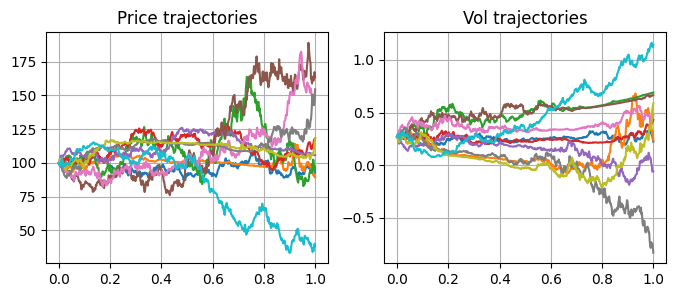

In [44]:
T = 1
F0 = 100

size = 10
N_grid = 500

t_grid = np.linspace(0, T, N_grid)
rng = np.random.default_rng(seed=42)
prices, vols = model.get_price_trajectory(t_grid=t_grid, size=size, F0=F0, rng=rng, return_vol=True)
prices

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
for price, vol in zip(prices, vols):
    ax[0].plot(t_grid, price)
    ax[1].plot(t_grid, vol)
ax[0].set_title("Price trajectories")
ax[1].set_title("Vol trajectories")
ax[0].grid()
ax[1].grid()

In [45]:
K = from_1_delta_call_to_strike(deltas = np.linspace(0.1, 0.9, 50), F0=F0, sigma=0.2, ttm=T)
option_call = VanillaOption(T=T, K=K, flag="call")
option_put = VanillaOption(T=T, K=K, flag="put")

In [46]:
%%time

size = 10**6

smile_mc_call, mc_call_lower, mc_call_upper = option_call.get_price(
    model=model, method="mc", F0=F0, is_vol_surface=True, 
    pricing_params=MCParams(size=size, batch_size=10_000, return_accuracy=True)
)

smile_mc_put, mc_put_lower, mc_put_upper = option_put.get_price(
    model=model, method="mc", F0=F0, is_vol_surface=True, 
    pricing_params=MCParams(size=size, batch_size=10_000, return_accuracy=True)
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [13:52<00:00,  8.32s/it]

CPU times: total: 13min 8s
Wall time: 27min 52s


In [47]:
smile_mc_put - smile_mc_call

array([0.00089384, 0.00087116, 0.00085157, 0.00083435, 0.00081903,
       0.00080524, 0.00079274, 0.00078134, 0.00077088, 0.00076124,
       0.00075234, 0.00074409, 0.00073645, 0.00072935, 0.00072276,
       0.00071665, 0.000711  , 0.00070577, 0.00070096, 0.00069655,
       0.00069255, 0.00068893, 0.00068571, 0.00068289, 0.00068046,
       0.00067844, 0.00067684, 0.00067567, 0.00067494, 0.00067467,
       0.00067489, 0.00067561, 0.00067686, 0.00067867, 0.00068107,
       0.00068411, 0.00068782, 0.00069225, 0.00069748, 0.00070357,
       0.00071061, 0.00071872, 0.00072802, 0.0007387 , 0.00075097,
       0.00076513, 0.00078156, 0.00080082, 0.00082366, 0.00085127])

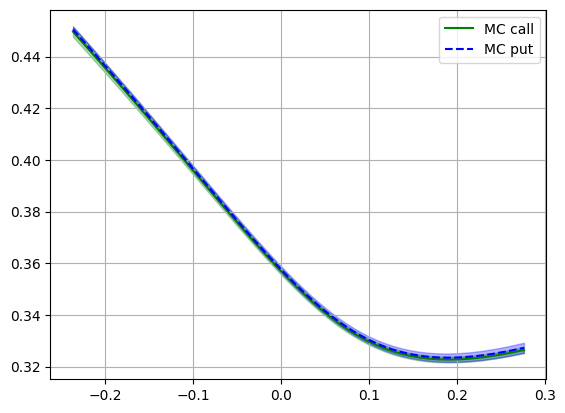

In [48]:
smile_mc_call_local_mart = smile_mc_call
smile_mc_put_local_mart = smile_mc_put

fig, ax = plt.subplots()
ax.plot(np.log(K / F0), smile_mc_call, "g", label="MC call")
ax.fill_between(np.log(K / F0), mc_call_lower, mc_call_upper, color="g", alpha=0.3)
ax.plot(np.log(K / F0), smile_mc_put, "b--", label="MC put")
ax.fill_between(np.log(K / F0), mc_put_lower, mc_put_upper, color="b", alpha=0.3)
ax.grid()
ax.legend()

In [49]:
d = dict()
d["put"] = dict()
d["put"]["price"] = smile_mc_put.tolist()
d["put"]["lower"] = mc_put_lower.tolist()
d["put"]["upper"] = mc_put_upper.tolist()

d["call"] = dict()
d["call"]["price"] = smile_mc_call.tolist()
d["call"]["lower"] = mc_call_lower.tolist()
d["call"]["upper"] = mc_call_upper.tolist()

import json
with open('smiles_N5_rho_neg' + "_lead" + str(leading_coef) + '.json', 'w') as f:
    json.dump(d, f)

## Strict local martingale, $N = 4$, $\rho > 0$

In [50]:
N = 4
rho = 0.9

rng = np.random.default_rng(seed=42)

len_arr = 2**(N+1) - 1
arr = np.round(rng.random(len_arr) - 0.5, 2)
arr[-1] = leading_coef
# arr = np.reshape(arr, (-1, 1, 1))
arr

array([ 0.27, -0.06,  0.36,  0.2 , -0.41,  0.48,  0.26,  0.29, -0.37,
       -0.05, -0.13,  0.43,  0.14,  0.32, -0.06, -0.27,  0.05, -0.44,
        0.33,  0.13,  0.26, -0.15,  0.47,  0.39,  0.28, -0.31, -0.03,
       -0.46, -0.35,  0.18,  0.  ])

In [51]:
model = SigVol(model_type="log-normal", 
               vol_ts=ta.from_array(trunc=N, array=arr), 
               ta=ta, 
               sigmas=lambda t: np.ones((len(t), 1)), R=[[1]], rhos=[rho])

In [52]:
ta.print(model.vol_ts)

0.27*∅ + -0.06*1 + 0.36*2 + 0.2*11 + -0.41*12 + 0.48*21 + 0.26*22 + 0.29*111 + -0.37*112 + -0.05*121 + -0.13*122 + 0.43*211 + 0.14*212 + 0.32*221 + -0.06*222 + -0.27*1111 + 0.05*1112 + -0.44*1121 + 0.33*1122 + 0.13*1211 + 0.26*1212 + -0.15*1221 + 0.47*1222 + 0.39*2111 + 0.28*2112 + -0.31*2121 + -0.03*2122 + -0.46*2211 + -0.35*2212 + 0.18*2221


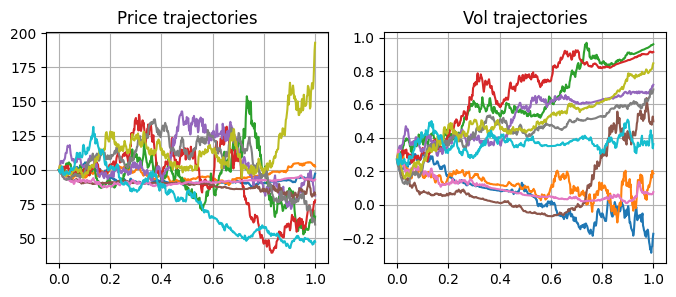

In [53]:
T = 1
F0 = 100

size = 10
N_grid = 500

t_grid = np.linspace(0, T, N_grid)
rng = np.random.default_rng(seed=42)
prices, vols = model.get_price_trajectory(t_grid=t_grid, size=size, F0=F0, rng=rng, return_vol=True)
prices

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
for price, vol in zip(prices, vols):
    ax[0].plot(t_grid, price)
    ax[1].plot(t_grid, vol)
ax[0].set_title("Price trajectories")
ax[1].set_title("Vol trajectories")
ax[0].grid()
ax[1].grid()

In [54]:
K = from_1_delta_call_to_strike(deltas = np.linspace(0.1, 0.9, 50), F0=F0, sigma=0.2, ttm=T)
option_call = VanillaOption(T=T, K=K, flag="call")
option_put = VanillaOption(T=T, K=K, flag="put")

In [55]:
%%time
smile_mc_call, mc_call_lower, mc_call_upper = option_call.get_price(
    model=model, method="mc", F0=F0, is_vol_surface=True, 
    pricing_params=MCParams(size=1_000_000, batch_size=10_000, return_accuracy=True)
)

smile_mc_put, mc_put_lower, mc_put_upper = option_put.get_price(
    model=model, method="mc", F0=F0, is_vol_surface=True, 
    pricing_params=MCParams(size=1_000_000, batch_size=10_000, return_accuracy=True)
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:53<00:00,  4.13s/it]

CPU times: total: 8min 33s
Wall time: 13min 49s


In [56]:
smile_mc_put - smile_mc_call

array([0.01868648, 0.01800799, 0.01744503, 0.01696887, 0.01656018,
       0.01620553, 0.01589507, 0.01562142, 0.0153789 , 0.01516302,
       0.0149702 , 0.01479752, 0.01464253, 0.01450316, 0.01437768,
       0.0142646 , 0.0141626 , 0.01407057, 0.01398753, 0.01391262,
       0.01384508, 0.01378426, 0.01372958, 0.01368053, 0.01363668,
       0.01359763, 0.01356306, 0.01353265, 0.01350617, 0.01348339,
       0.01346414, 0.01344827, 0.01343566, 0.01342621, 0.01341987,
       0.0134166 , 0.0134164 , 0.01341929, 0.01342535, 0.01343467,
       0.0134474 , 0.01346375, 0.01348399, 0.01350849, 0.01353773,
       0.01357234, 0.01361318, 0.01366141, 0.01371868, 0.01378742])

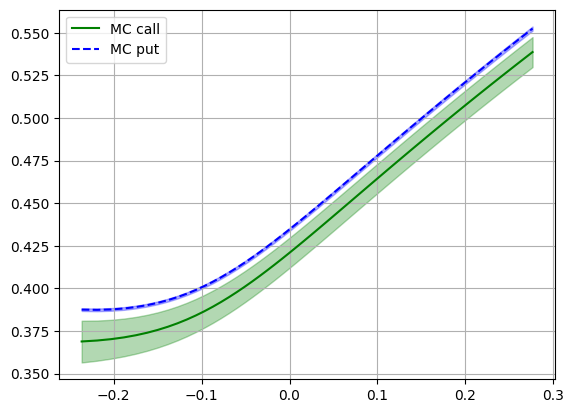

In [57]:
smile_mc_call_local_mart = smile_mc_call
smile_mc_put_local_mart = smile_mc_put

fig, ax = plt.subplots()
ax.plot(np.log(K / F0), smile_mc_call, "g", label="MC call")
ax.fill_between(np.log(K / F0), mc_call_lower, mc_call_upper, color="g", alpha=0.3)
ax.plot(np.log(K / F0), smile_mc_put, "b--", label="MC put")
ax.fill_between(np.log(K / F0), mc_put_lower, mc_put_upper, color="b", alpha=0.3)
ax.grid()
ax.legend()

In [58]:
d = dict()
d["put"] = dict()
d["put"]["price"] = smile_mc_put.tolist()
d["put"]["lower"] = mc_put_lower.tolist()
d["put"]["upper"] = mc_put_upper.tolist()

d["call"] = dict()
d["call"]["price"] = smile_mc_call.tolist()
d["call"]["lower"] = mc_call_lower.tolist()
d["call"]["upper"] = mc_call_upper.tolist()

import json
with open('smiles_N4_rho_pos' + "_lead" + str(leading_coef) + '.json', 'w') as f:
    json.dump(d, f)

## Strict local martingale, $N = 5$, $\rho > 0$

In [59]:
N = 5
rho = 0.9


rng = np.random.default_rng(seed=42)

len_arr = 2**(N+1) - 1
arr = np.round(rng.random(len_arr) - 0.5, 2)
arr[-1] = leading_coef
# arr = np.reshape(arr, (-1, 1, 1))
arr

array([ 0.27, -0.06,  0.36,  0.2 , -0.41,  0.48,  0.26,  0.29, -0.37,
       -0.05, -0.13,  0.43,  0.14,  0.32, -0.06, -0.27,  0.05, -0.44,
        0.33,  0.13,  0.26, -0.15,  0.47,  0.39,  0.28, -0.31, -0.03,
       -0.46, -0.35,  0.18,  0.24,  0.47, -0.17, -0.13, -0.03, -0.31,
       -0.37, -0.02, -0.27,  0.17, -0.06,  0.33,  0.2 , -0.19,  0.33,
        0.3 , -0.11, -0.21,  0.18, -0.36, -0.3 , -0.49,  0.29,  0.16,
        0.21,  0.28, -0.04,  0.07, -0.36, -0.39,  0.17, -0.03,  0.  ])

In [60]:
model = SigVol(model_type="log-normal", 
               vol_ts=ta.from_array(trunc=N, array=arr), 
               ta=ta, 
               sigmas=lambda t: np.ones((len(t), 1)), R=[[1]], rhos=[rho])

In [61]:
ta.print(model.vol_ts)

0.27*∅ + -0.06*1 + 0.36*2 + 0.2*11 + -0.41*12 + 0.48*21 + 0.26*22 + 0.29*111 + -0.37*112 + -0.05*121 + -0.13*122 + 0.43*211 + 0.14*212 + 0.32*221 + -0.06*222 + -0.27*1111 + 0.05*1112 + -0.44*1121 + 0.33*1122 + 0.13*1211 + 0.26*1212 + -0.15*1221 + 0.47*1222 + 0.39*2111 + 0.28*2112 + -0.31*2121 + -0.03*2122 + -0.46*2211 + -0.35*2212 + 0.18*2221 + 0.24*2222 + 0.47*11111 + -0.17*11112 + -0.13*11121 + -0.03*11122 + -0.31*11211 + -0.37*11212 + -0.02*11221 + -0.27*11222 + 0.17*12111 + -0.06*12112 + 0.33*12121 + 0.2*12122 + -0.19*12211 + 0.33*12212 + 0.3*12221 + -0.11*12222 + -0.21*21111 + 0.18*21112 + -0.36*21121 + -0.3*21122 + -0.49*21211 + 0.29*21212 + 0.16*21221 + 0.21*21222 + 0.28*22111 + -0.04*22112 + 0.07*22121 + -0.36*22122 + -0.39*22211 + 0.17*22212 + -0.03*22221


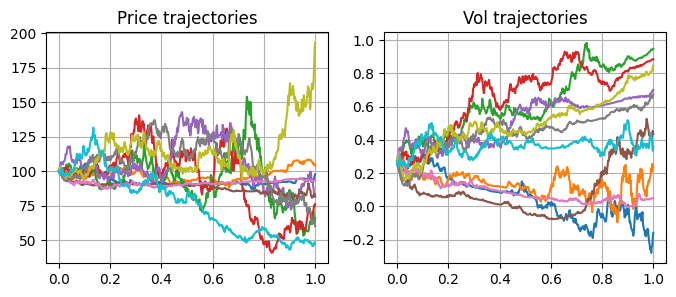

In [62]:
T = 1
F0 = 100

size = 10
N_grid = 500

t_grid = np.linspace(0, T, N_grid)
rng = np.random.default_rng(seed=42)
prices, vols = model.get_price_trajectory(t_grid=t_grid, size=size, F0=F0, rng=rng, return_vol=True)
prices

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
for price, vol in zip(prices, vols):
    ax[0].plot(t_grid, price)
    ax[1].plot(t_grid, vol)
ax[0].set_title("Price trajectories")
ax[1].set_title("Vol trajectories")
ax[0].grid()
ax[1].grid()

In [63]:
K = from_1_delta_call_to_strike(deltas = np.linspace(0.1, 0.9, 50), F0=F0, sigma=0.2, ttm=T)
option_call = VanillaOption(T=T, K=K, flag="call")
option_put = VanillaOption(T=T, K=K, flag="put")

In [64]:
%%time

size = 10**6

smile_mc_call, mc_call_lower, mc_call_upper = option_call.get_price(
    model=model, method="mc", F0=F0, is_vol_surface=True, 
    pricing_params=MCParams(size=size, batch_size=10_000, return_accuracy=True)
)

smile_mc_put, mc_put_lower, mc_put_upper = option_put.get_price(
    model=model, method="mc", F0=F0, is_vol_surface=True, 
    pricing_params=MCParams(size=size, batch_size=10_000, return_accuracy=True)
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [13:56<00:00,  8.37s/it]

CPU times: total: 14min 28s
Wall time: 27min 38s


In [65]:
smile_mc_put - smile_mc_call

array([0.04456123, 0.04287548, 0.04148536, 0.04031526, 0.03931479,
       0.03844931, 0.0376936 , 0.03702892, 0.03644093, 0.03591839,
       0.03545232, 0.03503542, 0.03466167, 0.03432602, 0.03402417,
       0.03375246, 0.03350775, 0.03328728, 0.03308866, 0.03290981,
       0.03274889, 0.03260431, 0.03247465, 0.03235868, 0.03225531,
       0.03216361, 0.03208275, 0.032012  , 0.03195075, 0.03189847,
       0.03185473, 0.03181913, 0.0317914 , 0.0317713 , 0.03175867,
       0.03175344, 0.03175558, 0.03176515, 0.03178229, 0.03180725,
       0.03184037, 0.03188215, 0.03193322, 0.03199444, 0.03206697,
       0.0321523 , 0.03225242, 0.0323701 , 0.03250921, 0.03267543])

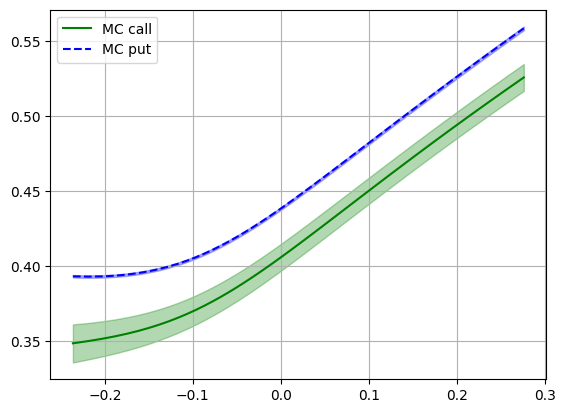

In [66]:
smile_mc_call_local_mart = smile_mc_call
smile_mc_put_local_mart = smile_mc_put

fig, ax = plt.subplots()
ax.plot(np.log(K / F0), smile_mc_call, "g", label="MC call")
ax.fill_between(np.log(K / F0), mc_call_lower, mc_call_upper, color="g", alpha=0.3)
ax.plot(np.log(K / F0), smile_mc_put, "b--", label="MC put")
ax.fill_between(np.log(K / F0), mc_put_lower, mc_put_upper, color="b", alpha=0.3)
ax.grid()
ax.legend()

In [67]:
d = dict()
d["put"] = dict()
d["put"]["price"] = smile_mc_put.tolist()
d["put"]["lower"] = mc_put_lower.tolist()
d["put"]["upper"] = mc_put_upper.tolist()

d["call"] = dict()
d["call"]["price"] = smile_mc_call.tolist()
d["call"]["lower"] = mc_call_lower.tolist()
d["call"]["upper"] = mc_call_upper.tolist()

import json
with open('smiles_N5_rho_pos' + "_lead" + str(leading_coef) + '.json', 'w') as f:
    json.dump(d, f)